# Import the libraries

In [339]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
from tqdm.notebook import tqdm

# Seed
import random
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

import matplotlib.pyplot as plt
%matplotlib inline

In [340]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Hyper-parameter setting

In [341]:
# Hyper-parameters

N_VALID = 0.4
NUM_WORKERS=0
NUM_EPOCHS= 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# Transforms

mean and std are pre-calculated

In [342]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip 
    #transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
    #                       contrast = 0.1,
     #                      saturation = 0.1),
    transforms.ToTensor(), # Converting image to tensor
    transforms.Normalize(([0.4914, 0.4822, 0.4465]), [0.2470, 0.2435, 0.2616]),
    transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(([0.4914, 0.4822, 0.4465]), [0.2470, 0.2435, 0.2616])
    ])

# Load the data

In [343]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                             download=True,
                                            transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True,
                                           transform=test_transform)

# Get indices for training_set and validation_set
n_train = len(train_dataset)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(N_VALID * n_train))
train_idx, valid_idx = indices[split:], indices[:split]






# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = train_sampler,
                                           num_workers = NUM_WORKERS
                                           )
valid_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size = BATCH_SIZE,
                                          sampler = valid_sampler,
                                          num_workers = NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          num_workers = NUM_WORKERS,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [344]:
# print shape of dataset for each set
for key, value in {'Train': train_loader, "Validation": valid_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Train:
Shape of X [N, C, H, W]: torch.Size([32, 3, 32, 32])
Shape of y: torch.Size([32]) torch.int64

Validation:
Shape of X [N, C, H, W]: torch.Size([32, 3, 32, 32])
Shape of y: torch.Size([32]) torch.int64

Test:
Shape of X [N, C, H, W]: torch.Size([32, 3, 32, 32])
Shape of y: torch.Size([32]) torch.int64



In [345]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualize a batch of training data

In [346]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

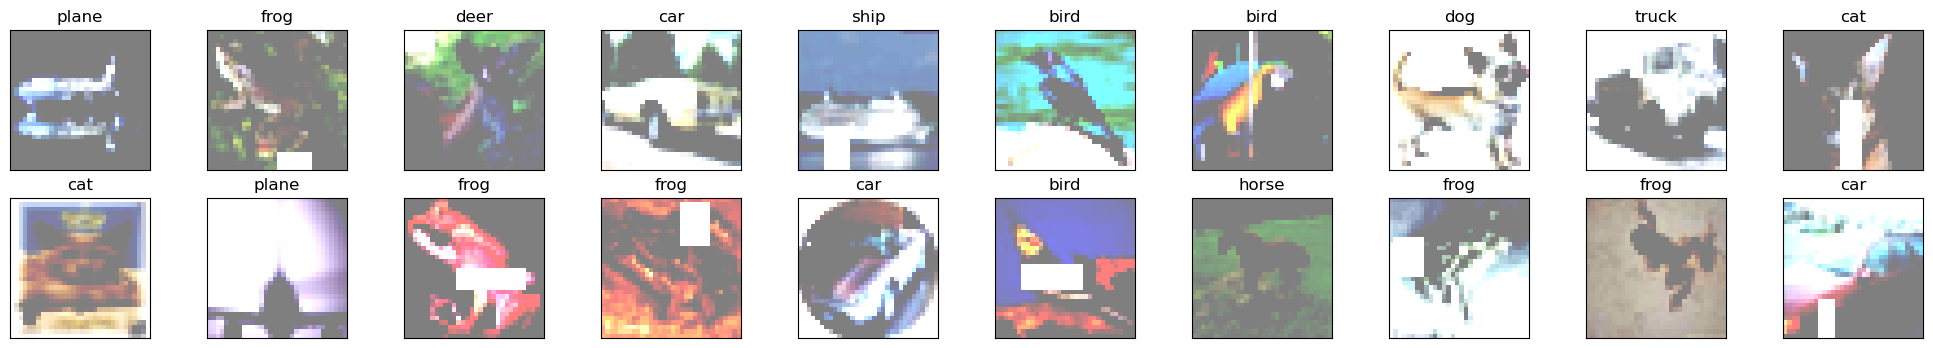

In [347]:
# Get one batch of training images
examples = iter(train_loader)
images, labels = next(examples)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    images[idx] = images[idx].clip(0, 1) # Clipping the size to print the images later
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Define CNN

In [358]:
class ConvNet_1(nn.Module):
    def __init__(self):
        super(ConvNet_1, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size =5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size = 5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 5, padding=2)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 2 * 2, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        # flattening
        x = x.view(-1, 128 * 2 * 2)            
        x = F.relu(self.fc1(x))         
        x = self.dropout(F.relu(self.fc2(x)))             
        x = self.fc3(x)                       
        return x
    
model = ConvNet_1().to(device)

In [359]:
# print summary of model like summary in tensorflow
summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet_1                                [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 32, 32]           456
├─MaxPool2d: 1-2                         [32, 6, 16, 16]           --
├─Conv2d: 1-3                            [32, 16, 16, 16]          2,416
├─MaxPool2d: 1-4                         [32, 16, 8, 8]            --
├─Conv2d: 1-5                            [32, 64, 8, 8]            25,664
├─MaxPool2d: 1-6                         [32, 64, 4, 4]            --
├─Conv2d: 1-7                            [32, 128, 4, 4]           204,928
├─MaxPool2d: 1-8                         [32, 128, 2, 2]           --
├─Linear: 1-9                            [32, 240]                 123,120
├─Linear: 1-10                           [32, 84]                  20,244
├─Dropout: 1-11                          [32, 84]                  --
├─Linear: 1-12                           [32, 10]              

# Loss function and optimizer

In [360]:
# Specify the Loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the network

In [361]:
valid_loss_min = float('inf') # track change in validation loss
#List to store loss to visualize
train_losslist = []
valid_losslist = []
val_accuracies = []

for epoch in range(1, NUM_EPOCHS+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    correct = total = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU 
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU 
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    
    # calculate average losses
    avg_train_loss = train_loss/len(train_loader.dataset)
    avg_valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_losslist.append(avg_train_loss)
    valid_losslist.append(avg_valid_loss)
    
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
  
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation accuracy: {: .4f}'.format(
        epoch, avg_train_loss, avg_valid_loss, round(val_accuracy*100, 2)))
    
    
    # save model if validation loss has decreased
    if avg_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = avg_valid_loss


Epoch: 1 	Training Loss: 1.141212 	Validation Loss: 0.638752 	Validation accuracy:  40.2700
Validation loss decreased (inf --> 0.638752).  Saving model ...
Epoch: 2 	Training Loss: 0.940870 	Validation Loss: 0.566107 	Validation accuracy:  48.2200
Validation loss decreased (0.638752 --> 0.566107).  Saving model ...
Epoch: 3 	Training Loss: 0.842270 	Validation Loss: 0.521574 	Validation accuracy:  52.5200
Validation loss decreased (0.566107 --> 0.521574).  Saving model ...
Epoch: 4 	Training Loss: 0.784532 	Validation Loss: 0.509849 	Validation accuracy:  54.0300
Validation loss decreased (0.521574 --> 0.509849).  Saving model ...
Epoch: 5 	Training Loss: 0.733517 	Validation Loss: 0.469202 	Validation accuracy:  58.1800
Validation loss decreased (0.509849 --> 0.469202).  Saving model ...
Epoch: 6 	Training Loss: 0.689203 	Validation Loss: 0.454646 	Validation accuracy:  59.5400
Validation loss decreased (0.469202 --> 0.454646).  Saving model ...
Epoch: 7 	Training Loss: 0.657822 	Vali

In [362]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

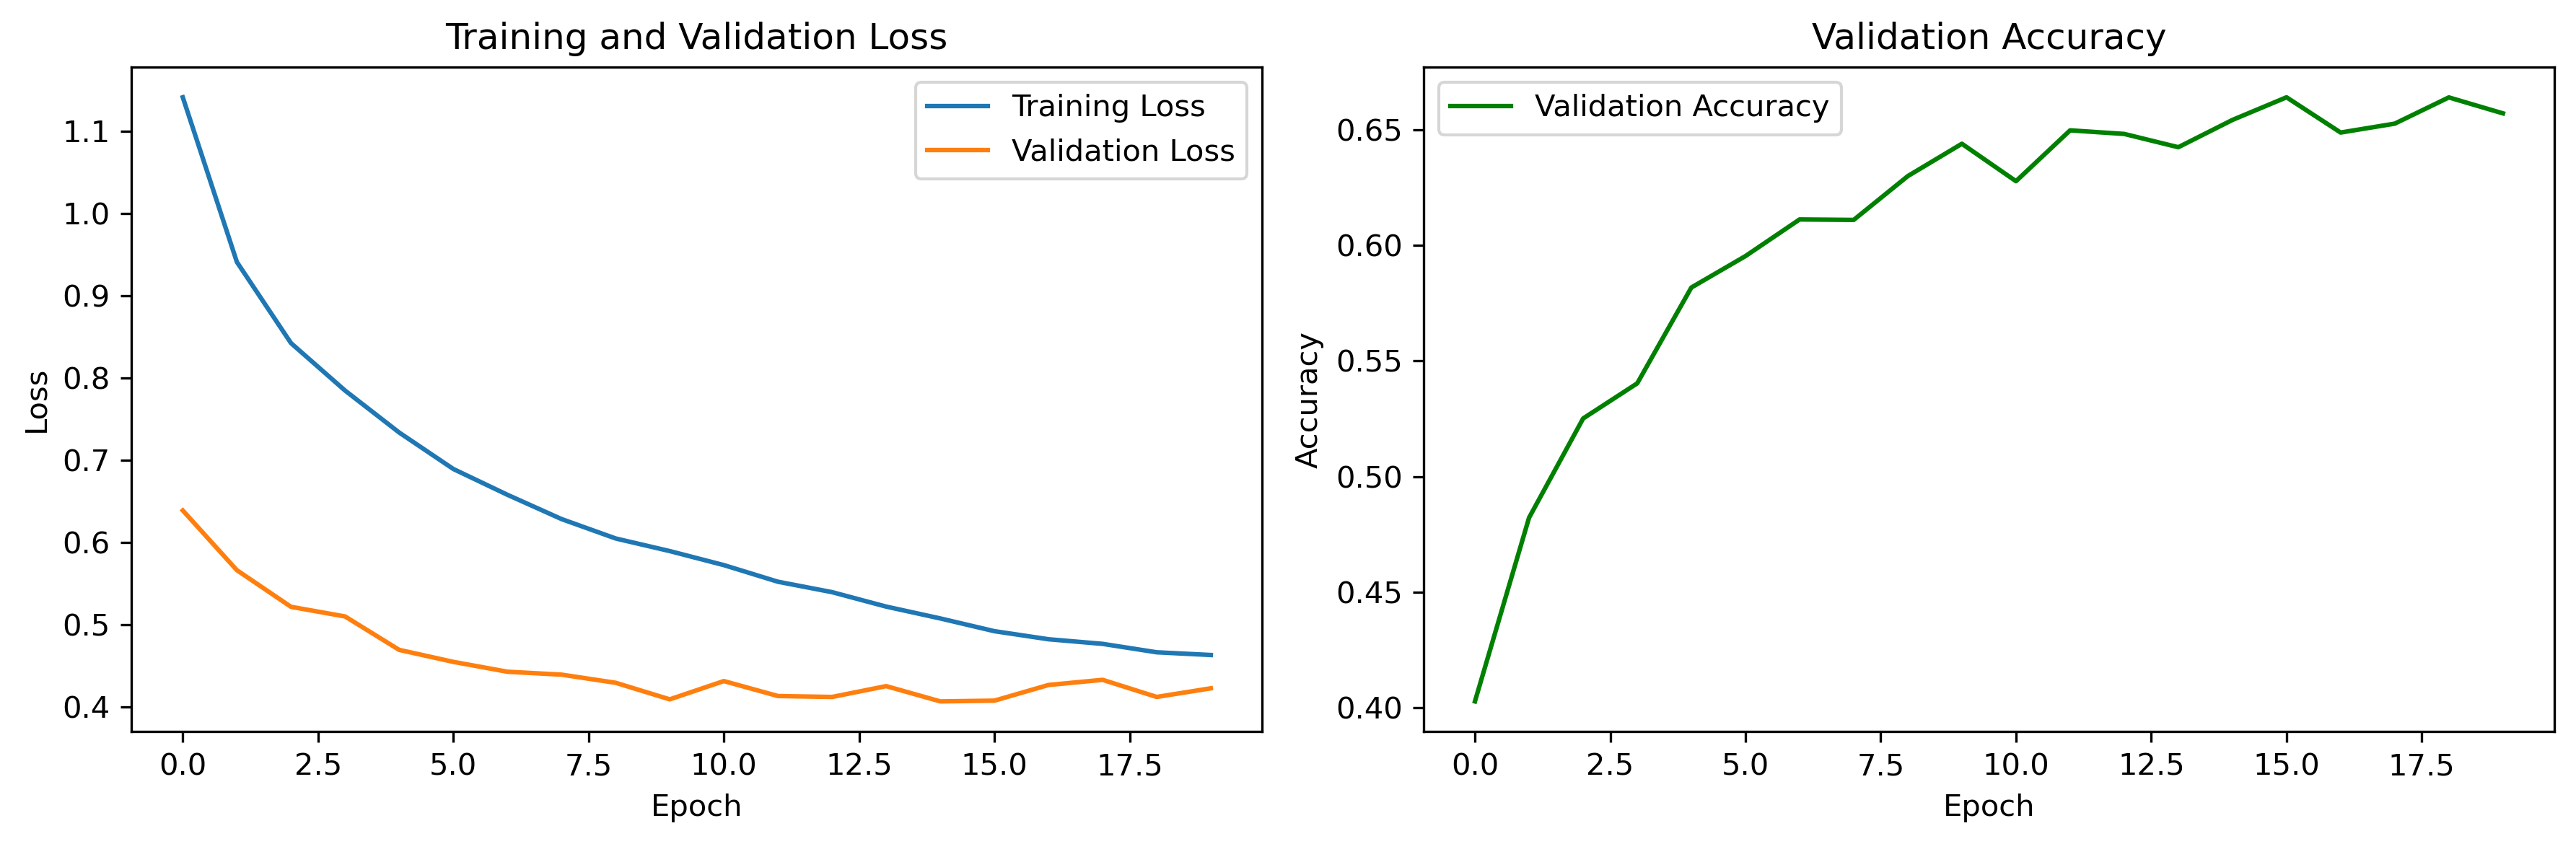

In [363]:
plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(train_losslist, label='Training Loss')
plt.plot(valid_losslist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [364]:
# test model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    tot_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {tot_acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 68.08 %
Accuracy of plane: 77.3 %
Accuracy of car: 82.4 %
Accuracy of bird: 53.1 %
Accuracy of cat: 46.8 %
Accuracy of deer: 66.8 %
Accuracy of dog: 42.6 %
Accuracy of frog: 78.7 %
Accuracy of horse: 73.2 %
Accuracy of ship: 86.6 %
Accuracy of truck: 73.3 %


# Summary

* It seems like our model struggles for images of cats, dogs and birds.